In [ ]:
import pandas as pd 
from nltk.corpus import stopwords
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
%matplotlib inline


# Question 1

### This function will prepare the text data by methods such 
- removing stop words
- cleaning the text data by removing puntuations
- removed numbers because while predicting the topic for news file numbers will not have huge impact and they have very less term frequency in news files
- tokenizing data 
- stemming data 
- POS tagging 

In [ ]:
data = pd.read_csv("df_Reuters_dataframe.csv")
data.head()

In [ ]:
data['headline_text'] = data['headline'] + data['text']

In [ ]:
nltk.download('stopwords')

nltk.download('punkt')
st = PorterStemmer()

nltk.download('wordnet')
word_lemmatizer=WordNetLemmatizer()

def prepare_data(data, column):
    
    df_Reuters =  {'text_data' : []}
    
    
    # converting to lower case 
    df_Reuters['text_data'] = data[column]
    
    df_Reuters['text_data']= df_Reuters['text_data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # removing puntuations 
    df_Reuters['text_data'] =  df_Reuters['text_data'].str.replace('[^\w\s]','')
    
    # removing numbers
    df_Reuters['text_data'] =  df_Reuters['text_data'].str.replace('\d+', '')
    
    # removing stop words     
    stop = stopwords.words('english')
    df_Reuters['text_data'] =  df_Reuters['text_data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))   
       
    #  tokenizing data 
    df_Reuters['text_token']=  df_Reuters['text_data'].apply(nltk.word_tokenize)
    
    # stemming data 
    df_Reuters['text_token'] = df_Reuters['text_token'].apply(lambda x:([st.stem(word) for word in x]))
    
    #  leminnizing data          
    df_Reuters['text_token'] = df_Reuters['text_token'].apply(lambda x:([word_lemmatizer.lemmatize(word) for word in x]))
    
    # POS_tagging 
    df_Reuters['text_tokens_pos'] = nltk.pos_tag(df_Reuters['text_token'])
    
    df_Reuters['text_data']=df_Reuters['text_token'].apply(lambda x : " ".join(x))
    
    data['headline_text'] = df_Reuters['text_data']

In [ ]:
text = 'headline_text'
prepare_data(data, text)

In [ ]:
data.to_csv("prepared_data.csv", sep=',', encoding='utf-8')

In [151]:
data = pd.read_csv("prepared_data.csv", index_col=0)

In [41]:
data.head()

,itemid,XMLfilename,headline,text,bip_topics,date_published,headline_text,htext_token
0,326914,326914newsML,Canadian Occidental mounts rival Wascana bid.,Canadian Occidental Petroleum Ltd. emerged on...,['C181'],1997-03-18,canadian occidental mounts rival wascana bid c...,"['canadian', 'occident', 'mount', 'rival', 'wa..."
1,326915,326915newsML,"Gruma, Maseca to receive syndicated loan - bank.",Bank of America will launch a three-year $120...,['C173'],1997-03-18,gruma maseca receive syndicated loan bank bank...,"['gruma', 'maseca', 'receiv', 'syndic', 'loan'..."
2,326916,326916newsML,Too early to call Krupp bid hostile - Deutsche...,Deutsche Bank AG management board member Rolf...,"['C18', 'C181', 'CCAT']",1997-03-18,early call krupp bid hostile deutsche bank deu...,"['earli', 'call', 'krupp', 'bid', 'hostil', 'd..."
3,326917,326917newsML,"FOCUS - Euro bourses fret over Wall St, electi...",European bourses fell on Tuesday even before ...,"['M11', 'M13', 'M132', 'M14', 'M142', 'MCAT']",1997-03-18,focus euro bourses fret wall st elections emu ...,"['focu', 'euro', 'bours', 'fret', 'wall', 'st'..."
4,326918,326918newsML,"French stocks fall, Alcatel posts big gain.",French shares closed lower on Tuesday in the ...,"['G152', 'M11']",1997-03-18,french stocks fall alcatel posts big gain fren...,"['french', 'stock', 'fall', 'alcatel', 'post',..."


# Question 2

## Obtaining document vectors using doc2vec

### We have used doc2vec for feature selection for clustering

In [152]:
def doc2vec(dataframe_text):
    LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
    all_content_train = []
    j=0
    for em in dataframe_text.values:
        all_content_train.append(LabeledSentence1(em,[j]))
        j+=1
    print('Number of texts processed: ', j)
    d2v_model = Doc2Vec(all_content_train)
    d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=3)
    
    return d2v_model.docvecs.doctag_syn0

In [153]:
document_doc2vec = doc2vec(data['headline_text']) #document doc2vec vectors

Number of texts processed:  48375


/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if sys.path[0] == '':


## Determining optimal cluster number

/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/Users/Patti/anaconda3/lib/python3.7

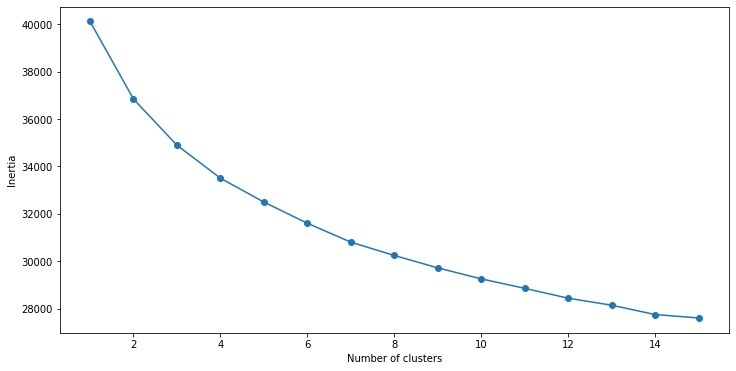

In [46]:
X = document_doc2vec
SST = []
for cluster in range(1,16):
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(X)
    SST.append(kmeans.inertia_)
    
    #converting the results into a dataframe and plotting them
    import matplotlib.pyplot as plt
    frame = pd.DataFrame({'Cluster':range(1,16), 'SSE':SST})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

### From the elbow curve we decided to divide the documents into 8 clusters but the k-means algorithm was putting the majority of the documents into 1 or 2 clusters leaving other with much fewer instances (<1000), therefore, we decided to divide the data in 4 clusters. 

## Kmeans clustering with 4 clusters

In [155]:
def kmeans_clustering(X, true_k):
    true_k = 4
    kmeans_model = KMeans(n_clusters=true_k).fit(X)
    cluster = kmeans_model.labels_
    
    return cluster

In [156]:
cluster_labels = kmeans_clustering(document_doc2vec, 4)

In [160]:
data['cluster_id'] = cluster_labels
data.head()


,XMLfilename,headline,text,bip_topics,date_published,headline_text,htext_token,cluster_id
itemid,,,,,,,,
326914,326914newsML,Canadian Occidental mounts rival Wascana bid.,Canadian Occidental Petroleum Ltd. emerged on...,['C181'],1997-03-18,canadian occidental mounts rival wascana bid c...,"['canadian', 'occident', 'mount', 'rival', 'wa...",2
326915,326915newsML,"Gruma, Maseca to receive syndicated loan - bank.",Bank of America will launch a three-year $120...,['C173'],1997-03-18,gruma maseca receive syndicated loan bank bank...,"['gruma', 'maseca', 'receiv', 'syndic', 'loan'...",0
326916,326916newsML,Too early to call Krupp bid hostile - Deutsche...,Deutsche Bank AG management board member Rolf...,"['C18', 'C181', 'CCAT']",1997-03-18,early call krupp bid hostile deutsche bank deu...,"['earli', 'call', 'krupp', 'bid', 'hostil', 'd...",0
326917,326917newsML,"FOCUS - Euro bourses fret over Wall St, electi...",European bourses fell on Tuesday even before ...,"['M11', 'M13', 'M132', 'M14', 'M142', 'MCAT']",1997-03-18,focus euro bourses fret wall st elections emu ...,"['focu', 'euro', 'bours', 'fret', 'wall', 'st'...",2
326918,326918newsML,"French stocks fall, Alcatel posts big gain.",French shares closed lower on Tuesday in the ...,"['G152', 'M11']",1997-03-18,french stocks fall alcatel posts big gain fren...,"['french', 'stock', 'fall', 'alcatel', 'post',...",2


In [161]:
data['cluster_id'].value_counts()

0    24676
2    10707
1     7752
3     5240
Name: cluster_id, dtype: int64

## Cluster visualization using PCA

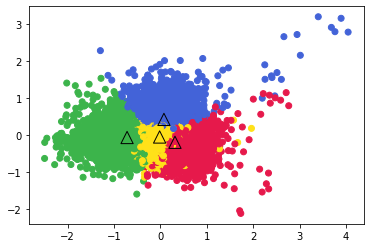

In [72]:
pca = PCA(n_components=2).fit(X)
datapoint = pca.transform(X)

labels=kmeans_model.labels_.tolist()
label=kmeans_model.labels_


plt.figure
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='None', edgecolor='black')
plt.show()

## Cluster visualization using t-SNE  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

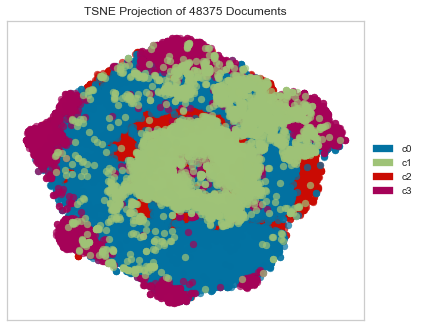

In [157]:
from yellowbrick.text.base import TextVisualizer
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer(learning_rate=1000.0)
tsne.fit(document_doc2vec, ["c{}".format(c) for c in cluster_labels])
tsne.show()

### t-SNE dose not give the proper visualization because all the documents are very close to each other. We tried to do parametere tuning on t-SNE, but it did not changed the visualization. 

## Why Doc2Vec instead of Tfidf:
- We first tried kmeans clustering based on Tfidf values for our dataset and then using doc2vec, an extension of word2vec. The average silhouette score for Tfidf was 0.053 compared to 0.076 for doc2vec so we decided to use the latter for our project.  Additionally one of our clusters contained approximately half of the documents in our dataset so we elected to do further kmeans clustering on it to prevent working with a large cluster and potentially running into memory issues when working with the data in the latter part of the project. 

## Why elbow graph to determine number of cluster: 
- To determine the optimal number of clusters (k) for the kmeans algorithm we used the elbow method, in which the sum of squared distances of samples to their closest cluster center is plotted against different values for k. The optimal number of clusters is the point where the curve starts decreasing in a liner fashion. We did not get a clear elbow but there is a slowing down of the rate of change of inertia between at k = 4 which is what we used. 

# Question 3

## Silhouette score and cluster visualization with PCA

In [ ]:
#code modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_analysis(X,num_clusters)
    range_n_clusters = [num_clusteres]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.6, 0.6])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='euclidean')

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for %d clusters" % n_clusters")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with %d clusters" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 4 The average silhouette_score is : 0.07638804


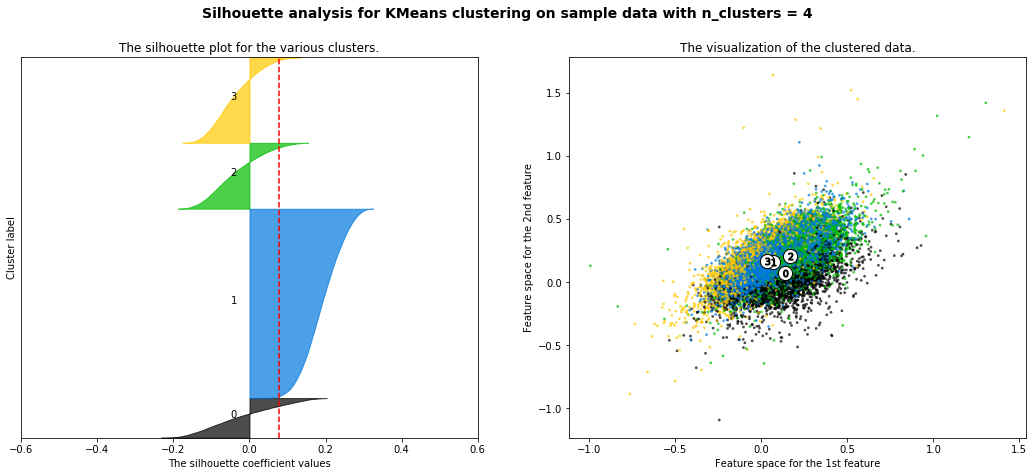

In [73]:
silhouette_analysis(X,4)

## Evaluating our clusters : 
- We used average silhouette score to evaluate our clustering method. Silhouette score is a measure of how similar on instance is to its own cluster compared with other clusters. Values range from +1 to -1. Values closer to +1 indicate sample is far away from other clusters, closer to 0 indicate a sample is very close or on the decision boundary between neighboring clusters and negative values indicate that the sample may have been assigned to the wrong cluster. 
- Our average silhouette score is 0.0764. Visualization with TSNE and PCA show that our document clusters are in close proximity/overlapping which explains why the results are close to 0 (many instances are close to the boundary of other cluster leading to silhouette scores closer to 0 and some instances may have been misclassified leading to negative silhouette scores.

In [5]:
data_cluster = pd.read_csv("clustered_data.csv", index_col=0)

In [163]:
data_cluster.head()

,XMLfilename,headline,text,bip_topics,date_published,headline_text,htext_token,cluster_id
itemid,,,,,,,,
326914,326914newsML,Canadian Occidental mounts rival Wascana bid.,Canadian Occidental Petroleum Ltd. emerged on...,['C181'],1997-03-18,canadian occidental mounts rival wascana bid c...,"['canadian', 'occident', 'mount', 'rival', 'wa...",0
326915,326915newsML,"Gruma, Maseca to receive syndicated loan - bank.",Bank of America will launch a three-year $120...,['C173'],1997-03-18,gruma maseca receive syndicated loan bank bank...,"['gruma', 'maseca', 'receiv', 'syndic', 'loan'...",2
326916,326916newsML,Too early to call Krupp bid hostile - Deutsche...,Deutsche Bank AG management board member Rolf...,"['C18', 'C181', 'CCAT']",1997-03-18,early call krupp bid hostile deutsche bank deu...,"['earli', 'call', 'krupp', 'bid', 'hostil', 'd...",2
326917,326917newsML,"FOCUS - Euro bourses fret over Wall St, electi...",European bourses fell on Tuesday even before ...,"['M11', 'M13', 'M132', 'M14', 'M142', 'MCAT']",1997-03-18,focus euro bourses fret wall st elections emu ...,"['focu', 'euro', 'bours', 'fret', 'wall', 'st'...",0
326918,326918newsML,"French stocks fall, Alcatel posts big gain.",French shares closed lower on Tuesday in the ...,"['G152', 'M11']",1997-03-18,french stocks fall alcatel posts big gain fren...,"['french', 'stock', 'fall', 'alcatel', 'post',...",2


In [164]:
data_cluster['cluster_id'].value_counts()

2    24110
0    10950
3     8299
1     5016
Name: cluster_id, dtype: int64

In [5]:
cluster_0 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 0])
cluster_1 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 1])
cluster_2 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 2])
cluster_3 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 3])

### Splitting cluster 2 into 5 clusters

In [165]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in cluster_2['headline_text'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  8299


In [166]:
d2v_model_2 = Doc2Vec(all_content_train)
d2v_model_2.train(all_content_train, total_examples=d2v_model_2.corpus_count, epochs=3)


/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [167]:
cluster2doc2vec = d2v_model_2.docvecs.doctag_syn0 
true_k =5
kmeans_model = KMeans(n_clusters=true_k).fit(X)
cluster_2_labels = kmeans_model.labels_

/Users/Patti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


## t-SNE Visualizer for 5 clusters 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

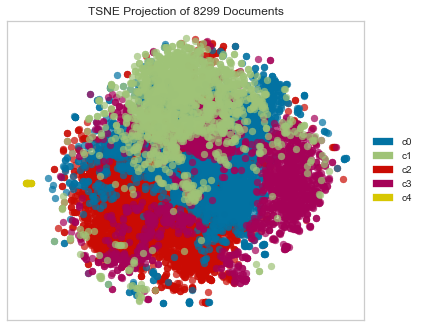

In [169]:
tsne = TSNEVisualizer(learning_rate=1000.0)
tsne.fit(cluster2doc2vec, ["c{}".format(c) for c in cluster_2_labels])
tsne.show()

In [10]:
cluster_2['cluster_id'] = lables_cluster_2
cluster_2.head()

,XMLfilename,headline,text,bip_topics,date_published,headline_text,htext_token,cluster_id
itemid,,,,,,,,
326915,326915newsML,"Gruma, Maseca to receive syndicated loan - bank.",Bank of America will launch a three-year $120...,['C173'],1997-03-18,gruma maseca receive syndicated loan bank bank...,"['gruma', 'maseca', 'receiv', 'syndic', 'loan'...",0
326916,326916newsML,Too early to call Krupp bid hostile - Deutsche...,Deutsche Bank AG management board member Rolf...,"['C18', 'C181', 'CCAT']",1997-03-18,early call krupp bid hostile deutsche bank deu...,"['earli', 'call', 'krupp', 'bid', 'hostil', 'd...",4
326918,326918newsML,"French stocks fall, Alcatel posts big gain.",French shares closed lower on Tuesday in the ...,"['G152', 'M11']",1997-03-18,french stocks fall alcatel posts big gain fren...,"['french', 'stock', 'fall', 'alcatel', 'post',...",1
368471,368471newsML,Indonesian officials safe in helicopter emerge...,Two Indonesian government ministers and other...,"['GCAT', 'GDIS', 'GPOL']",1997-03-13,indonesian officials safe helicopter emergency...,"['indonesian', 'offici', 'safe', 'helicopt', '...",1
368472,368472newsML,Hindu Brahmin convert to succeed Mother Teresa.,A former Hindu Brahmin who converted to Roman...,"['GCAT', 'GPRO', 'GREL']",1997-03-13,hindu brahmin convert succeed mother teresa fo...,"['hindu', 'brahmin', 'convert', 'succeed', 'mo...",0


In [11]:
cluster_2['cluster_id'].value_counts()

0    6509
2    5285
1    5013
3    4748
4    2555
Name: cluster_id, dtype: int64

## Cluster visualization using PCA with 5 clusters 

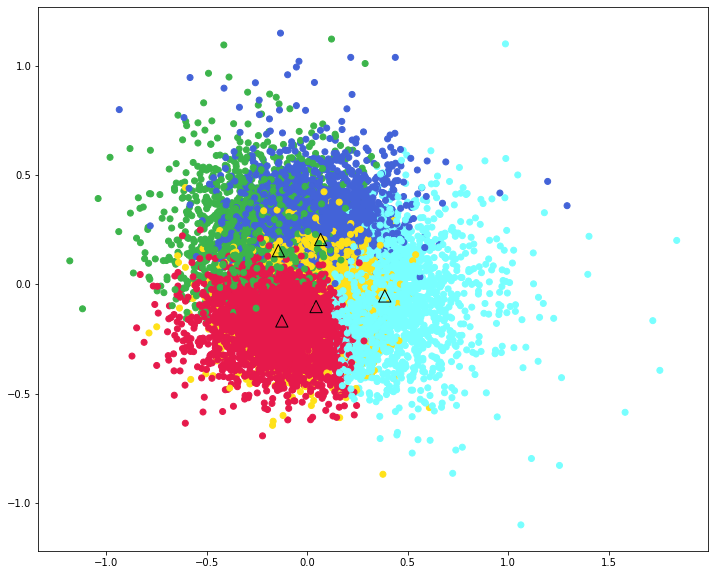

In [12]:
pca = PCA(n_components=2).fit(X)
datapoint = pca.transform(X)

labels=kmeans_model.labels_.tolist()
label=kmeans_model.labels_


plt.figure
plt.figure(figsize=(12,10))
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#78ffff']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)

plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='None', edgecolor='black')
plt.show()

## Silhouette graph and score for 5 clusters 

For n_clusters = 5 The average silhouette_score is : 0.06146887


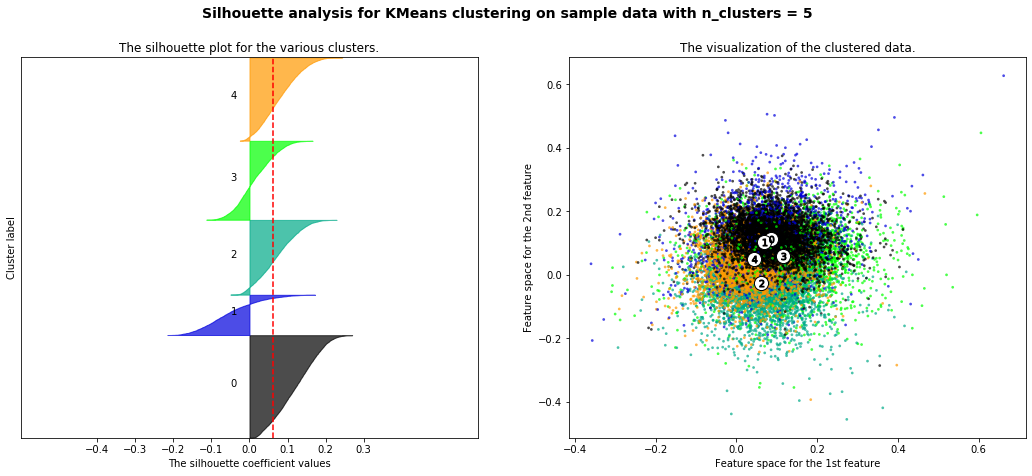

In [13]:
silhouette_analysis(X,5)

In [14]:
cluster_4 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 0])
cluster_5 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 1])
cluster_6 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 2])
cluster_7 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 3])
cluster_8 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 4])

In [17]:
cluster_8.head()

,XMLfilename,headline,text,bip_topics,date_published,headline_text,htext_token,cluster_id
itemid,,,,,,,,
326916,326916newsML,Too early to call Krupp bid hostile - Deutsche...,Deutsche Bank AG management board member Rolf...,"['C18', 'C181', 'CCAT']",1997-03-18,early call krupp bid hostile deutsche bank deu...,"['earli', 'call', 'krupp', 'bid', 'hostil', 'd...",4
368475,368475newsML,Indian chemicals prices - Delhi - March 13.,"Rates supplied by Asian News International, N...","['M14', 'MCAT']",1997-03-13,indian chemicals prices delhi march rates supp...,"['indian', 'chemic', 'price', 'delhi', 'march'...",4
377588,377588newsML,Eurowings sees higher 1996 profits.,German airline Eurowings Luftverkehrs AG said...,"['C15', 'C152', 'CCAT']",1997-03-13,eurowings sees higher profits german airline e...,"['eurow', 'see', 'higher', 'profit', 'german',...",4
377589,377589newsML,Royale Belge backs Belgian bank merger.,Royale Belge chief executive officer Jean-Pie...,"['C11', 'C18', 'C181', 'CCAT']",1997-03-13,royale belge backs belgian bank merger royale ...,"['royal', 'belg', 'back', 'belgian', 'bank', '...",4
393164,393164newsML,Kredietbank stock div to fund expansion.,"Kredietbank, one of Belgium's top four banks,...","['C15', 'C151', 'CCAT']",1997-03-13,kredietbank stock div fund expansion kredietba...,"['kredietbank', 'stock', 'div', 'fund', 'expan...",4


## Wordcloud Cluster Representation

In [29]:
def plot_wordCount(cluster):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 

  
    # iterate through the csv file 
    for val in cluster.text: 
      
        # typecaste each val to string 
        val = str(val) 
  
        # split the value 
        tokens = val.split() 
      
    # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
          
        for words in tokens: 
            comment_words = comment_words + words + ' '
  
  
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 


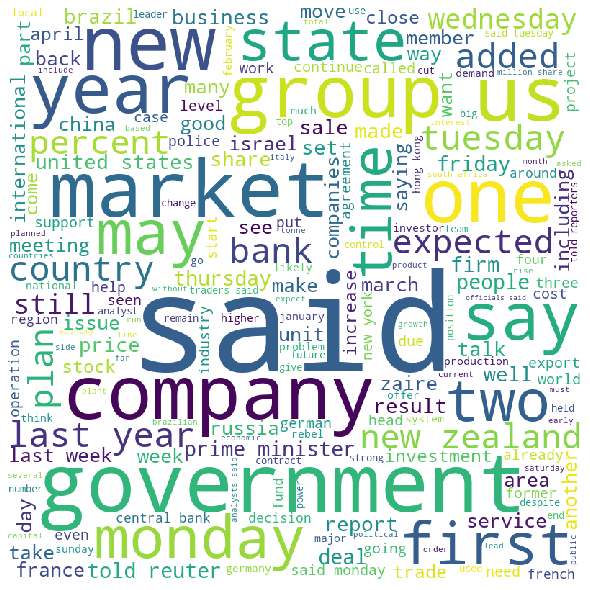

In [52]:
plot_wordCount(cluster_1)

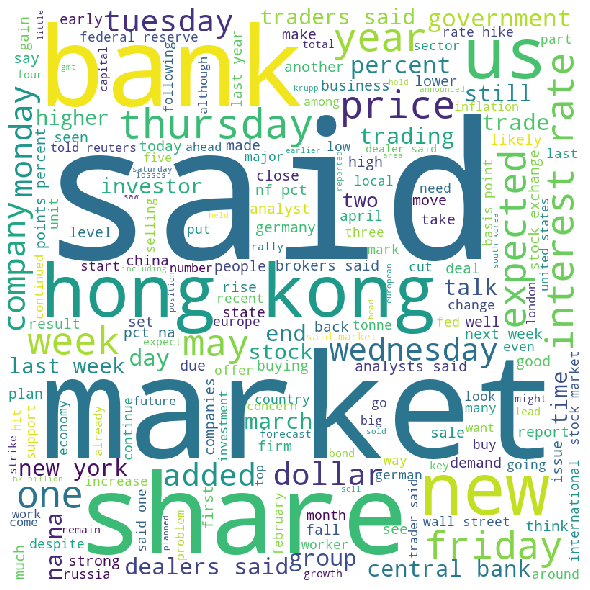

In [53]:
plot_wordCount(cluster_7)

In [ ]:
cluster_0 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 0])
cluster_1 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 1])
cluster_2 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 2])
cluster_3 = pd.DataFrame(data_cluster.loc[data_cluster['cluster_id'] == 3])
cluster_4 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 0])
cluster_5 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 1])
cluster_6 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 2])
cluster_7 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 3])
cluster_8 = pd.DataFrame(cluster_2.loc[cluster_2['cluster_id'] == 4])

In [3]:
cluster_0 =cluster_0.dropna()
cluster_1 =cluster_1.dropna()
cluster_2 =cluster_2.dropna()
cluster_3 =cluster_3.dropna()
cluster_4 =cluster_4.dropna()
cluster_5 =cluster_5.dropna()
cluster_6 =cluster_6.dropna()
cluster_7 =cluster_7.dropna()

In [31]:
cluster_0.to_csv("cluster_0.csv", sep=',', encoding='utf-8')
cluster_1.to_csv("cluster_1.csv", sep=',', encoding='utf-8')
cluster_3.to_csv("cluster_2.csv", sep=',', encoding='utf-8')
cluster_4.to_csv("cluster_3.csv", sep=',', encoding='utf-8')
cluster_5.to_csv("cluster_4.csv", sep=',', encoding='utf-8')
cluster_6.to_csv("cluster_5.csv", sep=',', encoding='utf-8')
cluster_7.to_csv("cluster_6.csv", sep=',', encoding='utf-8')
cluster_8.to_csv("cluster_7.csv", sep=',', encoding='utf-8')

In [9]:
cluster_0 = pd.read_csv("cluster_0.csv", index_col=0)
cluster_1 = pd.read_csv("cluster_1.csv", index_col=0)
cluster_2 = pd.read_csv("cluster_2.csv", index_col=0)
cluster_3 = pd.read_csv("cluster_3.csv", index_col=0)
cluster_4 = pd.read_csv("cluster_4.csv", index_col=0)
cluster_5 = pd.read_csv("cluster_5.csv", index_col=0)
cluster_6 = pd.read_csv("cluster_6.csv", index_col=0)
cluster_7 = pd.read_csv("cluster_7.csv", index_col=0)

### Tfidf vectorization method

In [14]:
def tfidf_vector(samples):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(samples)
   
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    text_vector = tfidf_vectorizer.fit_transform(samples)
    print (text_vector.shape)
    
    return text_vector

### SVM classifier method

In [22]:
def Classifire_SVM(TextVector, labels):
    X_train, X_test, y_train, y_test = train_test_split(TextVector, labels,test_size=0.30, random_state = 50)
    C = 1.0  # SVM regularization parameter
    clf = svm.SVC(kernel='linear',gamma='scale', C=C)
    svc = clf.fit(X_train, y_train)
    predicted = svc.predict(X_test)
    print (" Accuracy score : %.5f" % metrics.accuracy_score(y_test, predicted))
    print (" F1 Score :%.5f" % metrics.f1_score(y_test, predicted, average='weighted',labels=np.unique(predicted)))

### Random Forest classifier method

In [23]:
def Classifire_RandomForest(TextVector, labels):
    X_train, X_test, y_train, y_test = train_test_split(TextVector, labels,test_size=0.30, random_state = 50)
    clf = RandomForestClassifier()
    rfc = clf.fit(X_train, y_train)
    predicted = rfc.predict(X_test)
    print (" Accuracy score :%.5f" % metrics.accuracy_score(y_test, predicted))
    print (" F1 Score :%.5f" % metrics.f1_score(y_test, predicted, average='weighted',labels=np.unique(predicted)))

### Neural netowrk classifier method

In [24]:
def Classifire_NN(TextVector, labels):
    X_train, X_test, y_train, y_test = train_test_split(TextVector, labels,test_size=0.30, random_state = 50)
    clf = MLPClassifier()
    NN = clf.fit(X_train, y_train)                        
    predicted = NN.predict(X_test)
    print (" Accuracy score :%.5f" % metrics.accuracy_score(y_test, predicted))
    print (" F1 Score :%.5f" % metrics.f1_score(y_test, predicted, average='weighted',labels=np.unique(predicted)))

## Classification without feature extration

### Classifier for cluster 1 

In [25]:
text_vector_0 = tfidf_vector(cluster_0['headline_text'])

(10927, 5000)


In [26]:
Classifire_SVM(text_vector_0,cluster_0['topics'])

 Accuracy score : 0.78012
 F1 Score :0.78150


In [12]:
Classifire_RandomForest(text_vector_0,cluster_0['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.65569
 F1 Score :0.63223


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
Classifire_NN(text_vector_0,cluster_0['topics'])

 Accuracy score :0.76334
 F1 Score :0.76107


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Classifier for cluster 2 

In [14]:
text_vector_1 = tfidf_vector(cluster_1['headline_text'])

(5004, 5000)


In [27]:
Classifire_SVM(text_vector_1,cluster_1['topics'])

 Accuracy score : 0.72636
 F1 Score :0.71816


In [16]:
Classifire_RandomForest(text_vector_1,cluster_1['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.62916
 F1 Score :0.60021


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
Classifire_NN(text_vector_1,cluster_1['topics'])

 Accuracy score :0.73302
 F1 Score :0.72570


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Classifier for cluster 3 

In [18]:
text_vector_2 = tfidf_vector(cluster_2['headline_text'])

(8282, 5000)


In [28]:
Classifire_SVM(text_vector_2,cluster_2['topics'])

 Accuracy score : 0.76579
 F1 Score :0.76160


In [29]:
Classifire_RandomForest(text_vector_2,cluster_2['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.65594
 F1 Score :0.63170


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
Classifire_NN(text_vector_2,cluster_2['topics'])

 Accuracy score :0.76539
 F1 Score :0.76420


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Classifier for cluster 4 

In [31]:
text_vector_3 = tfidf_vector(cluster_3['headline_text'])

(6486, 5000)


In [32]:
Classifire_SVM(text_vector_3,cluster_3['topics'])

 Accuracy score : 0.78777
 F1 Score :0.78269


In [33]:
Classifire_RandomForest(text_vector_3,cluster_3['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.65827
 F1 Score :0.62519


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
Classifire_NN(text_vector_3,cluster_3['topics'])

 Accuracy score :0.79188
 F1 Score :0.79026


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Classifier for cluster 5  

In [35]:
text_vector_4 = tfidf_vector(cluster_4['headline_text'])

(5004, 5000)


In [36]:
Classifire_SVM(text_vector_4,cluster_4['topics'])

 Accuracy score : 0.75899
 F1 Score :0.75357


In [37]:
Classifire_RandomForest(text_vector_4,cluster_4['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.63582
 F1 Score :0.60662


In [38]:
Classifire_NN(text_vector_4,cluster_4['topics'])

 Accuracy score :0.76897
 F1 Score :0.76430


### Classifier for cluster 6

In [39]:
text_vector_5= tfidf_vector(cluster_5['headline_text'])

(5270, 5000)


In [40]:
Classifire_SVM(text_vector_5,cluster_5['topics'])

 Accuracy score : 0.77546
 F1 Score :0.76947


In [41]:
Classifire_RandomForest(text_vector_5,cluster_5['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.64010
 F1 Score :0.60586


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [42]:
Classifire_NN(text_vector_5,cluster_5['topics'])

 Accuracy score :0.76597
 F1 Score :0.76145


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Classifier for cluster 7

In [43]:
text_vector_6 = tfidf_vector(cluster_6['headline_text'])

(4735, 5000)


In [44]:
Classifire_SVM(text_vector_6,cluster_6['topics'])

 Accuracy score : 0.77973
 F1 Score :0.77720


In [45]:
Classifire_RandomForest(text_vector_6,cluster_6['topics'])

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Accuracy score :0.65376
 F1 Score :0.62462


In [46]:
Classifire_NN(text_vector_6,cluster_6['topics'])

 Accuracy score :0.77340
 F1 Score :0.76648


### Classifier for cluster 8

In [47]:
text_vector_7 = tfidf_vector(cluster_7['headline_text'])

(2549, 5000)


In [48]:
Classifire_SVM(text_vector_7,cluster_7['topics'])

 Accuracy score : 0.75556
 F1 Score :0.75399


In [49]:
Classifire_RandomForest(text_vector_7,cluster_7['topics'])

 Accuracy score :0.64706
 F1 Score :0.62638


D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [50]:
Classifire_NN(text_vector_7,cluster_7['topics'])

 Accuracy score :0.75033
 F1 Score :0.74812


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [29]:
cluster0 = pd.read_csv("cluster_0.csv", index_col=0)
cluster1 = pd.read_csv("cluster_1.csv", index_col=0)
cluster2 = pd.read_csv("cluster_2.csv", index_col=0)
cluster3 = pd.read_csv("cluster_3.csv", index_col=0)
cluster4 = pd.read_csv("cluster_4.csv", index_col=0)
cluster5 = pd.read_csv("cluster_5.csv", index_col=0)
cluster6 = pd.read_csv("cluster_6.csv", index_col=0)
cluster7 = pd.read_csv("cluster_7.csv", index_col=0)

In [21]:
cluster0 = cluster0.dropna()
cluster1 = cluster1.dropna()
cluster2 = cluster2.dropna()
cluster3 = cluster3.dropna()
cluster4 = cluster4.dropna()
cluster5 = cluster5.dropna()
cluster6 = cluster6.dropna()
cluster7 = cluster7.dropna()

In [31]:
cluster0_tfidf = tfidf_vector(cluster0['headline_text'])
cluster1_tfidf = tfidf_vector(cluster1['headline_text'])
cluster2_tfidf = tfidf_vector(cluster2['headline_text'])
cluster3_tfidf = tfidf_vector(cluster3['headline_text'])
cluster4_tfidf = tfidf_vector(cluster4['headline_text'])
cluster5_tfidf = tfidf_vector(cluster5['headline_text'])
cluster6_tfidf = tfidf_vector(cluster6['headline_text'])
cluster7_tfidf = tfidf_vector(cluster7['headline_text'])

## SVM Parameter Grid Search 

In [34]:
from sklearn.model_selection import train_test_split
HX_train, HX_test, Hy_train, Hy_test = train_test_split(cluster0_extracted, cluster0['topics'],test_size=0.20, random_state = 50)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
def GridSearch_SVM(TextVector, labels):
    X_train, X_test, y_train, y_test = train_test_split(TextVector, labels,test_size=0.30, random_state = 50)
    parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 10], 'gamma':['scale', 'auto']}
    svc = svm.SVC()
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(svc, parameters, cv = kfold)
    grid_result = grid_search.fit(X_train, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    

In [39]:
GridSearch_SVM(HX_train, Hy_train)

# Question 4

## Autoencoder 

- We chose to use a feed-forward autoencoder because it allowed us to do feature extraction in a cost effective manner on our machines. We were able to achieve similar accuracies using Tfidf on SVM in less time with 85% less features. This autoencoder was not difficult to implement or execute with our data. The autoencoder is composed of of an encoder and a decoder. The encoder, which consists of decreasing fully connected (dense) layers, identifies a latent feature representation of the input data. The decoder, which consists of increasing fully connected layers, then uses that representation to reconstruct the input. As the autoencoder decreases the reconstruction error, the encoder learns the important features of the input data. We also investigated convolutional autoencoders but were unable to implement an executable version on our machines.

In [10]:
def autoencoder(cluster_features):
    input_text = Input(shape=(cluster_features.shape[1],))
    encoded = Dense(units=1100, activation='linear')(input_text)
    encoded = Dense(units=700, activation='linear')(encoded)
    decoded = Dense(units=1100, activation='linear')(encoded)
    decoded = Dense(units=cluster_features.shape[1], activation='softmax')(decoded)

    autoencoder=Model(input_text, decoded)
    encoder=Model(input_text, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    autoencoder.fit(cluster_features, cluster_features,
                epochs=3,
                shuffle=True,)
    return encoder

In [11]:
def extract_features(model, cluster_features):
        return model.predict(cluster_features)

# Question 5

## Classification with feature extraction

### Cluster 1

In [22]:
cluster0_encoder = autoencoder(cluster0_tfidf)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/3
10950/10950 [==============================] - 563s 51ms/step - loss: 0.0111 - acc: 0.9828
Epoch 2/3
10950/10950 [==============================] - 481s 44ms/step - loss: 0.0100 - acc: 0.9828
Epoch 3/3
10950/10950 [==============================] - 410s 37ms/step - loss: 0.0093 - acc: 0.9828


In [33]:
cluster0_extracted = extract_features(cluster0_encoder,cluster0_tfidf)

In [56]:
Classifire_SVM(cluster0_extracted, cluster0['topics'])

Accuracy score: 0.75206 
F1 Score: 0.75423 


### Cluster 2

In [177]:
cluster1_encoder = autoencoder(cluster1_tfidf)

Epoch 1/3
5004/5004 [==============================] - 213s 43ms/step - loss: 0.0125 - acc: 0.9802
Epoch 2/3
5004/5004 [==============================] - 216s 43ms/step - loss: 0.0118 - acc: 0.9802
Epoch 3/3
5004/5004 [==============================] - 210s 42ms/step - loss: 0.0111 - acc: 0.9802


In [113]:
cluster1_extracted = extract_features(cluster1_encoder,cluster1_tfidf)

In [58]:
Classifire_SVM(cluster1_extracted, cluster1['topics'])

Accuracy score: 0.71305 
F1 Score: 0.70725 


### Cluster 3

In [178]:
cluster2_encoder = autoencoder(cluster2_tfidf)

Epoch 1/3
8282/8282 [==============================] - 320s 39ms/step - loss: 0.0117 - acc: 0.9821
Epoch 2/3
8282/8282 [==============================] - 271s 33ms/step - loss: 0.0105 - acc: 0.9821
Epoch 3/3
8282/8282 [==============================] - 277s 33ms/step - loss: 0.0098 - acc: 0.9821


In [116]:
cluster2_extracted = extract_features(cluster2_encoder,cluster2_tfidf)

In [59]:
Classifire_SVM(cluster2_extracted, cluster2['topics'])

Accuracy score: 0.75453 
F1 Score: 0.75036 


### Cluster 4

In [179]:
cluster3_encoder = autoencoder(cluster3_tfidf)

Epoch 1/3
6486/6486 [==============================] - 217s 33ms/step - loss: 0.0100 - acc: 0.9874
Epoch 2/3
6486/6486 [==============================] - 196s 30ms/step - loss: 0.0093 - acc: 0.9874
Epoch 3/3
6486/6486 [==============================] - 192s 30ms/step - loss: 0.0086 - acc: 0.9874


In [119]:
cluster3_extracted = extract_features(cluster3_encoder,cluster3_tfidf)

In [60]:
Classifire_SVM(cluster3_extracted, cluster3['topics'])

Accuracy score: 0.76465 
F1 Score: 0.76535


### Cluster 5

In [180]:
cluster4_encoder = autoencoder(cluster4_tfidf)

Epoch 1/3
5004/5004 [==============================] - 171s 34ms/step - loss: 0.0102 - acc: 0.9868
Epoch 2/3
5004/5004 [==============================] - 167s 33ms/step - loss: 0.0096 - acc: 0.9868
Epoch 3/3
5004/5004 [==============================] - 148s 30ms/step - loss: 0.0090 - acc: 0.9868


In [122]:
cluster4_extracted = extract_features(cluster4_encoder,cluster4_tfidf)

In [61]:
Classifire_SVM(cluster4_extracted, cluster4['topics'])

Accuracy score: 0.72770 
F1 Score: 0.72810


### Cluster 6

In [181]:
cluster5_encoder = autoencoder(cluster5_tfidf)

Epoch 1/3
5270/5270 [==============================] - 174s 33ms/step - loss: 0.0101 - acc: 0.9876
Epoch 2/3
5270/5270 [==============================] - 162s 31ms/step - loss: 0.0095 - acc: 0.9876
Epoch 3/3
5270/5270 [==============================] - 159s 30ms/step - loss: 0.0088 - acc: 0.9876


In [125]:
cluster5_extracted = extract_features(cluster5_encoder,cluster5_tfidf)

In [62]:
Classifire_SVM(cluster5_extracted, cluster5['topics'])

Accuracy score: 0.74130 
F1 Score: 0.73739


### Cluster 7

In [182]:
cluster6_encoder = autoencoder(cluster6_tfidf)

Epoch 1/3
4735/4735 [==============================] - 158s 33ms/step - loss: 0.0099 - acc: 0.9881
Epoch 2/3
4735/4735 [==============================] - 143s 30ms/step - loss: 0.0093 - acc: 0.9881
Epoch 3/3
4735/4735 [==============================] - 144s 30ms/step - loss: 0.0087 - acc: 0.9881


In [128]:
cluster6_extracted = extract_features(cluster6_encoder,cluster6_tfidf)

In [63]:
Classifire_SVM(cluster6_extracted, cluster6['topics'])

Accuracy score: 0.75299 
F1 Score: 0.75268


### Cluster 8

In [175]:
cluster7_encoder = autoencoder(cluster7_tfidf)

Epoch 1/3
2549/2549 [==============================] - 94s 37ms/step - loss: 0.0126 - acc: 0.9803
Epoch 2/3
2549/2549 [==============================] - 90s 35ms/step - loss: 0.0120 - acc: 0.9803
Epoch 3/3
2549/2549 [==============================] - 87s 34ms/step - loss: 0.0117 - acc: 0.9803


In [173]:
cluster7_extracted = extract_features(cluster7_encoder,cluster7_tfidf)

In [55]:
Classifire_SVM(cluster7_extracted, cluster7['topics'])

Accuracy score: 0.71373 
F1 Score: 0.72631 


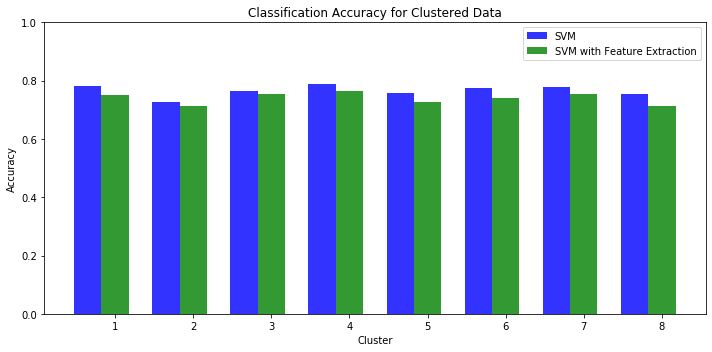

In [55]:
import numpy as np
import matplotlib.pyplot as plt

n_groups = 8
svm = (0.78012,0.72636,0.76579,0.78777,0.75899,0.77546,0.77973,0.75556)
svm_extract = (0.75206,0.71305,0.75453,0.76465,0.72770,0.74130,0.75299,0.71373)

fig = plt.figure(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, svm, bar_width,
alpha=opacity,
color='b',
label='SVM')

rects2 = plt.bar(index + bar_width, svm_extract, bar_width,
alpha=opacity,
color='g',
label='SVM with Feature Extraction')

plt.xlabel('Cluster')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy for Clustered Data')
plt.ylim(0,1)
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5','6','7','8'))
plt.legend()

plt.tight_layout()
plt.show()

## Why SVM as our classifier:
- We chose to use SVM as our classifier because it gave us higher accuracies than Neural Network and Random Forest classifiers for our data (see classification without feature extraction).

## Comparison with assignment 1
- In assignment 1 we used all Tfidf features for each document for classification whereas in this project we used word2vec to cluster similar documents before using feature extraction on each cluster to reduce 5000 Tfidf features to 700 features. In the previous assignment with close to 100k features we achieved 78% to 79% accuracy with our classifier. In this project with the combination of clustering and feature extraction, with just 700 features, we still able to achieve 73% to 76% accuracy. It is clear that deep neural network technique for feature extraction allows one to achieve similar accuracy in a time, cost and memory effective manner. The decrease in accuracy using feature extraction can be explained by there being some degree of memory loss between 100k features and 700. But since the change in accuracy is minimal it is suffice to say that feature extraction is able to retain the most importan features for classification.

> References

[1]"3.2.4.3.1. sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accessed: 26- Oct- 2019].

[2]"3.3. Model evaluation: quantifying the quality of predictions — scikit-learn 0.21.3 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/model_evaluation.html. [Accessed: 26- Oct- 2019].

[3]U. code), "Understanding Support Vector Machines algorithm (along with code)", Analytics Vidhya, 2019. [Online]. Available: https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/. [Accessed: 26- Oct- 2019].

[4]"Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures - Exsilio Blog", Exsilio Blog, 2019. [Online]. Available: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/. [Accessed: 26- Oct- 2019].

[5]"Accuracy, Precision, Recall or F1?", Medium, 2019. [Online]. Available: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. [Accessed: 26- Oct- 2019].

[6]Cs.cornell.edu, 2019. [Online]. Available: https://www.cs.cornell.edu/people/tj/publications/joachims_97b.pdf. [Accessed: 26- Oct- 2019].

[7]"3.2.4.3.1. sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accessed: 26- Oct- 2019].

[8]"os — Miscellaneous operating system interfaces — Python 3.8.0 documentation", Docs.python.org, 2019. [Online]. Available: https://docs.python.org/3/library/os.html#os.listdir. [Accessed: 26- Oct- 2019].

[9]"build pandas dataframe from a for loop", Welcome to python-forum.io, 2019. [Online]. Available: https://python-forum.io/Thread-build-pandas-dataframe-from-a-for-loop. [Accessed: 26- Oct- 2019].

[10]"Reading and Writing XML Files in Python", Stack Abuse, 2019. [Online]. Available: 
https://stackabuse.com/reading-and-writing-xml-files-in-python/. [Accessed: 26- Oct- 2019].

[11]"Selecting the number of clusters with silhouette analysis on KMeans clustering" Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. [Accessed: 12- Nov - 2019]

[12] "models.doc2vec – Doc2vec paragraph embeddings", gensim, 2019. [Online]. Available: 
https://radimrehurek.com/gensim/models/doc2vec.html. [Accessed: 12- Nov- 2019].

[13] "sklearn.cluster.KMeans — scikit-learn 0.22 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html [Accessed: 12- Nov - 2019]

[14]"sklearn.manifold.TSNE — scikit-learn 0.22 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. [Accessed: 12- Nov- 2019].

[15]"t-SNE Corpus Visualization — Yellowbrick v1.0.1 documentation", Scikit-yb.org, 2019. [Online]. Available: https://www.scikit-yb.org/en/latest/api/text/tsne.html. [Accessed: 12-  Nov - 2019].

[16]"Generating Word Cloud in Python - GeeksforGeeks", GeeksforGeeks, 2019. [Online]. Available: https://www.geeksforgeeks.org/generating-word-cloud-python/. [Accessed: 12- Dec- 2019].

[17] "Building Autoencoders in Keras", Blog.keras.io, 2019. [Online] Available at: https://blog.keras.io/building-autoencoders-in-keras.html [Accessed: 12- Dec- 2019].

[18] "Elbow Method for optimal value of k in KMeans - GeeksforGeeks", GeeksforGeeks, 2019. [Online] Available at: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/ [Accessed: 12- Dec- 2019].

[19] "Matplotlib Bar chart", pythonspot, 2019.  [Online] Available at: https://pythonspot.com/matplotlib-bar-chart/ [Accessed 9- Dec- 2019].